In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import seaborn as sns
from datetime import datetime 
import re
import warnings
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## 0. 데이터 불러오기

In [2]:
user_info = pd.read_csv("../../data/glowpick_user_info_new.csv")

del user_info["Unnamed: 0"]

## 1. 리뷰어 세분화

### 1-1. 군집 기법에 쓰일 3가지 변수 정규화 (MinMaxScaling)

In [3]:
user_info_new = user_info.copy()

scaler = MinMaxScaler()

for col in ["mean_review_time_lag", "review_recency", "total_review_num"]:
    
    scaled_figures = scaler.fit_transform(np.array(user_info_new[col]).reshape(-1,1))
    
    user_info_new[col] = [f[0] for f in scaled_figures]

### 1-2. hierarchical clustering 진행

In [4]:
train_data = user_info_new[["mean_review_time_lag", "review_recency", "total_review_num"]].values


def get_clustering_result(k, data):
    
    ## model building    
    model = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward')
    cluster = model.fit_predict(data)
    user_info_new["cluster"] = cluster
    

    # Figure

    figure = plt.figure(figsize=(12, 10))
    ax = figure.add_subplot(projection="3d")
    ax.set_xlabel("평균 리뷰 작성 주기")
    ax.set_ylabel("총 작성 리뷰 수")
    ax.set_zlabel("최근 활동도")


    # Data and 3D scatter
    colors = ["red", "blue", "purple", "black", "pink"]

    sc = ax.scatter(user_info_new.mean_review_time_lag, user_info_new.total_review_num, user_info_new.review_recency,
                    alpha=0.6, c =user_info_new.cluster,marker="o")

    # Legend 1
    handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
    legend1 = ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper center", title="고객 집단")
    ax.add_artist(legend1) # <- this is important.

    plt.show()
    
def get_RFM_summary(user_info, cluster):
    
    user_stat_df = user_info.loc[user_info.cluster == cluster]
    
    print("전체 유저 RFM Summary")
    
    print("""
    Recency 평균: %.2f
    Frequency 평균: %.2f
    Monetary 평균: %.2f
    """%(user_info.review_recency.mean(), user_info.mean_review_time_lag.mean(),user_info.total_review_num.mean()))
    
    
    print("%s번째 유저 집단 RFM Summary"%(cluster))
    
    print("""
    Recency 평균: %.2f
    Frequency 평균: %.2f
    Monetary 평균: %.2f   
    """%(user_stat_df.review_recency.mean(), user_stat_df.mean_review_time_lag.mean(),user_stat_df.total_review_num.mean()))

### 1-3. 계층적 군집화 결과

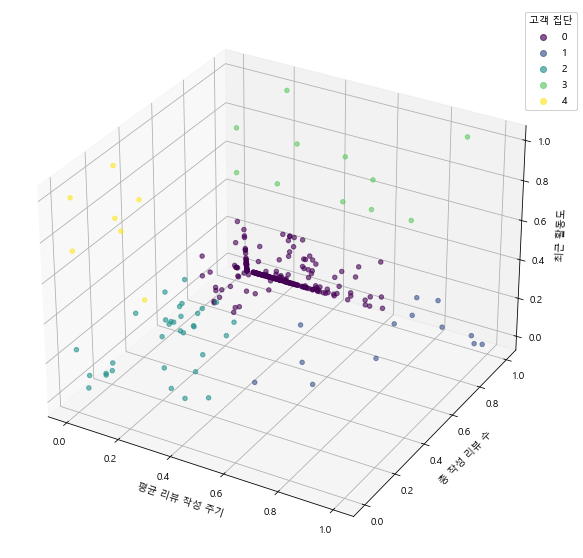

In [5]:
get_clustering_result(k = 5, data  = train_data)

### 1-4. k-means 결과에서 얻은 군집 산점도와 색깔 맞추기

In [6]:
user_info_new_modified = user_info_new.copy()

user_info_new_modified.loc[user_info_new.cluster == 2, "cluster"] = 3
user_info_new_modified.loc[user_info_new.cluster == 3, "cluster"] = 4
user_info_new_modified.loc[user_info_new.cluster == 4, "cluster"] = 2

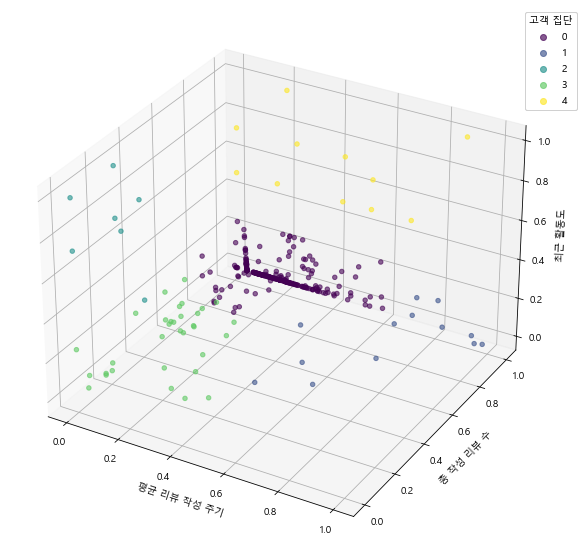

In [7]:
# Figure

figure = plt.figure(figsize=(12, 10))
ax = figure.add_subplot(projection="3d")
ax.set_xlabel("평균 리뷰 작성 주기")
ax.set_ylabel("총 작성 리뷰 수")
ax.set_zlabel("최근 활동도")


# Data and 3D scatter
colors = ["red", "blue", "purple", "black", "pink"]

sc = ax.scatter(user_info_new_modified.mean_review_time_lag, user_info_new_modified.total_review_num, user_info_new_modified.review_recency,
                alpha=0.6, c =user_info_new_modified.cluster,marker="o")

# Legend 1
handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
legend1 = ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper center", title="고객 집단")
ax.add_artist(legend1) # <- this is important.

plt.show()

* 이전 k-means clustering의 결과와 비교해 보았을 때, 0번째와 1번째 집단 사이의 차이 외에는 전체적으로 비슷한 군집화 결과를 보였으며, "최근 활동도" 기준으로 보았을 때는 k-means clustering 결과와 동일한 결과를 얻은 것을 확인할 수 있다. 

### 1-5. 각 집단 별 RFM 평균 값 산출

In [8]:
user_info_summary = user_info.merge(user_info_new_modified[["nickname", "cluster"]], on = "nickname")

In [9]:
get_RFM_summary(user_info_summary, 0)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
0번째 유저 집단 RFM Summary

    Recency 평균: 3.89
    Frequency 평균: 8.55
    Monetary 평균: 49.26   
    


In [10]:
get_RFM_summary(user_info_summary, 1)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
1번째 유저 집단 RFM Summary

    Recency 평균: 5.69
    Frequency 평균: 35.85
    Monetary 평균: 40.31   
    


In [11]:
get_RFM_summary(user_info_summary, 2)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
2번째 유저 집단 RFM Summary

    Recency 평균: 93.86
    Frequency 평균: 1.85
    Monetary 평균: 10.14   
    


In [12]:
get_RFM_summary(user_info_summary, 3)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
3번째 유저 집단 RFM Summary

    Recency 평균: 10.52
    Frequency 평균: 5.55
    Monetary 평균: 19.85   
    


In [13]:
get_RFM_summary(user_info_summary, 4)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
4번째 유저 집단 RFM Summary

    Recency 평균: 84.73
    Frequency 평균: 19.69
    Monetary 평균: 48.18   
    


* 산점도를 통해 얻은 결과와 같이, 0번째와 1번째 집단의 Frequency, Monetary 점수의 일정 정도 차이 외에 모든 집단에 대해서 거의 동일한 RFM 평균 점수를 볼 수가 있고, 특히 프로젝트의 휴면고객을 발굴하는 목적에 비추어보았을 때, Recency 점수 면에서 모든 집단이 거의 동일한 평균 점수를 가진다는 면에서, k-means의 군집화 결과는 우리 프로젝트의 목적에 맞게 robust 하다고 판단